In [2]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### With scikit learn

In [9]:
df = pd.read_csv('../../clean-HSC-unWISE-W02.csv')
w02 = pd.read_table('HSC-unWISE-W02.dat', delim_whitespace=True, usecols=[0,1], names=['ra','dec'])
    # usecols=[0,1,16,17,18], names=['ra','dec','phot_z', 'phot_z_err', 'log_st_mass']

In [10]:
nbrs = NearestNeighbors(n_neighbors= 6, algorithm='ball_tree', n_jobs = -1, metric= 'haversine') # the first neighbor is the point itself
nbrs.fit(np.deg2rad(w02[['dec', 'ra']].values)) # fit it to the whole sample

# coordinates must be in radians, and in order (lat, long)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html#sklearn.metrics.pairwise.haversine_distances

NearestNeighbors(algorithm='ball_tree', metric='haversine', n_jobs=-1,
                 n_neighbors=6)

In [11]:
n_all = nbrs.kneighbors(np.deg2rad(df[['dec', 'ra']].values), return_distance= True)  # find neighbors only for my sample
ang_dist_5 = np.rad2deg(n_all[0][:,5])  # angular distances to 5th neighbor

In [12]:
# convert to Mpc
lcmd = FlatLambdaCDM(H0=70, Om0=0.3)
mpc_deg = lcmd.kpc_proper_per_arcmin(df['phot_z'].values).value / 1000 * 60  # Mpc/degree
dist_5 = ang_dist_5 * mpc_deg
dist_5

array([0.2948799 , 0.14920495, 0.12545555, ..., 0.20129689, 0.20026219,
       0.17987526])

In [13]:
sigma_5 = 5/ np.pi /dist_5**2
sigma_5

array([ 18.30331649,  71.49137737, 101.12076815, ...,  39.27769396,
        39.68461951,  49.1900524 ])

Text(0.5, 0, 'sigma_5')

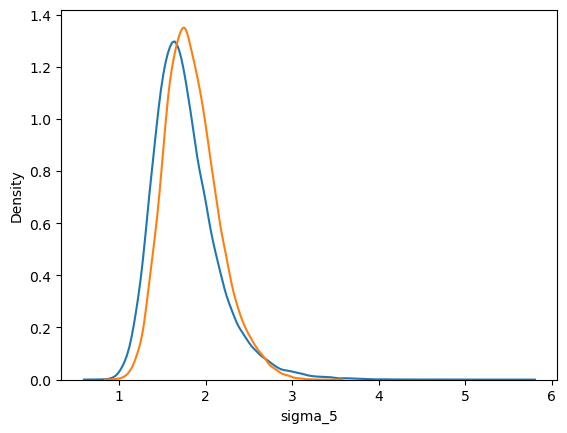

In [17]:
sns.kdeplot(np.log10(sigma_5[(df.member == 0)]), label = 'Non members', common_norm = True)
sns.kdeplot(np.log10(sigma_5[(df.member == 1)]), label = 'Members', common_norm = True)
plt.xlabel('sigma_5')

Text(0, 0.5, 'log(sigma_5)')

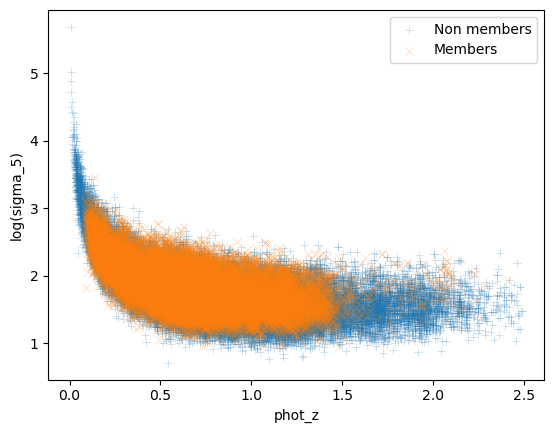

In [5]:
sns.scatterplot(x = df.phot_z[df.member == 0], y = np.log10(df['sigma_5'][df.member == 0]), marker = '+', alpha = 0.3, label = 'Non members')
sns.scatterplot(x = df.phot_z[df.member == 1], y = np.log10(df['sigma_5'][df.member == 1]), marker = 'x', alpha = 0.3, label = 'Members')
plt.ylabel('log(sigma_5)')

### With grispy

In [8]:
import grispy

grid = grispy.GriSPy(w02[['ra','dec']].values, metric='haversine', periodic = {0: (0,360), 1:None})
dsts, inds = grid.nearest_neighbors(df[['ra', 'dec']].values, n=6) 

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
deg_per_mpc = 1000. / (cosmo.kpc_proper_per_arcmin(df['phot_z'].values) * 60.) 

dstsMPC = [i/j for i, j in zip(dsts, deg_per_mpc)]
# df['dis5']=-1.0
# df['dis5']=np.array([i[-1] for i in dstsMPC])

s5 = [5./(np.pi*(i[-1])**2) for i in dstsMPC]